In [1]:

from __future__ import print_function

import sys

# sys.path.extend(['/home/jogi/git/repository/dcnn_acdc'])
sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm


from datetime import datetime
from pytz import timezone
import itertools
import copy

import SimpleITK as sitk
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from config.config import config
from utils.experiment import Experiment, ExperimentHandler
from utils.batch_handlers import TwoDimBatchHandler
from utils.test_handler import ACDC2017TestHandler
from plotting.learning_curves import loss_plot

from models.dilated_cnn import BaseDilated2DCNN

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"
CYCLE_OFFSET = 100000

SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True

np.random.seed(SEED)

In [3]:
exper_base = ExperimentHandler.load_experiment("/home/jorg/repository/dcnn_acdc/logs/20180308_12_04_41_dcnnv1_150000E_lr2e02")
exper_hdl_base = ExperimentHandler(exper_base, use_logfile=False)
exper_hdl_base.set_root_dir(ROOT_DIR)

Load from /home/jorg/repository/dcnn_acdc/logs/20180308_12_04_41_dcnnv1_150000E_lr2e02/stats/exper_stats.dll


In [4]:
# Mixed model 1 (0.5)
exper_mc_mix = ExperimentHandler.load_experiment("/home/jorg/repository/dcnn_acdc/logs/20180312_07_51_21_dcnn_mcv1_150000E_lr2e02")
exper_hdl_mc_mix = ExperimentHandler(exper_mc_mix, use_logfile=False)
exper_hdl_mc_mix.set_root_dir(ROOT_DIR)

Load from /home/jorg/repository/dcnn_acdc/logs/20180312_07_51_21_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll


In [5]:
# Mixed model 2 (0.2)
exper_mc_mix2 = ExperimentHandler.load_experiment("/home/jorg/repository/dcnn_acdc/logs/20180313_08_23_55_dcnn_mcv1_150000E_lr2e02")
exper_hdl_mc_mix2 = ExperimentHandler(exper_mc_mix2, use_logfile=False)
exper_hdl_mc_mix2.set_root_dir(ROOT_DIR)


Load from /home/jorg/repository/dcnn_acdc/logs/20180313_08_23_55_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll


In [4]:
exper_mc = ExperimentHandler.load_experiment("/home/jorg/repository/dcnn_acdc/logs/20180308_12_05_35_dcnn_mcv1_150000E_lr2e02")
exper_hdl_mc = ExperimentHandler(exper_mc, use_logfile=False)
exper_hdl_mc.set_root_dir(ROOT_DIR)
test_set = ACDC2017TestHandler(exper_config=exper_hdl_mc.exper.config, 
                               search_mask=config.dflt_image_name + ".mhd", fold_ids=[3],
                               debug=False, batch_size=4, use_cuda=True)

  0%|          | 0/4 [00:00<?, ?it/s]

Load from /home/jorg/repository/dcnn_acdc/logs/20180308_12_05_35_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
INFO - Testhandler - >>> Search for /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/*patient*.mhd <<<
INFO - File list contains 200 files
0 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient006_frame01.mhd
1 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient006_frame16.mhd


 25%|██▌       | 1/4 [00:00<00:02,  1.06it/s]

2 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient007_frame01.mhd
3 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient007_frame07.mhd


 50%|█████     | 2/4 [00:01<00:01,  1.16it/s]/home/jorg/anaconda2/envs/pyt_0_3_0/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


4 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient008_frame01.mhd
5 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient008_frame13.mhd


 75%|███████▌  | 3/4 [00:02<00:00,  1.29it/s]

6 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient009_frame01.mhd
7 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient009_frame13.mhd


100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

INFO - Successfully loaded 4 ED/ES patient pairs


In [17]:
def test_ensemble(test_set, exper_hdl, mc_samples=10, sample_weights=True, use_uncertainty=False,
                 std_threshold=None, image_range=None):
    # checkpoints = np.arange(CYCLE_OFFSET, 150001, 10000)
    checkpoints = [150000]
    # checkpoints = [10000, 50000, 100000, 150000]
    exper_hdl.test_results = None
    if use_uncertainty:
        print("INFO - Using {:.2f} as uncertainty threshold".format(std_threshold))
    for checkpoint in checkpoints:
        dcnn_model = exper_hdl.load_checkpoint(verbose=False, drop_prob=0.1, checkpoint=checkpoint)
        if image_range is None:
            image_range = np.arange(len(test_set.images))
        num_of_images = len(test_set.images)
        print("INFO - Running test on {} images".format(num_of_images))
        for image_num in image_range:
            exper_hdl.test(dcnn_model, test_set, image_num=image_num, sample_weights=sample_weights, 
                           mc_samples=mc_samples, compute_hd=True, use_uncertainty=use_uncertainty, 
                           std_threshold=std_threshold)
        del dcnn_model



In [19]:
exper_hdl_mc.logger = None
test_ensemble(test_set, exper_hdl_mc, mc_samples=10, sample_weights=True,  use_uncertainty=True, std_threshold=0.15)
exper_hdl_mc.test_results.generate_slice_statistics(image_num=0)

# INFO - Using 0.15 as uncertainty threshold
# Test accuracy: test loss -1.817	 dice(RV/Myo/LV): ES 0.93/0.91/0.92 --- ED 0.93/0.88/0.97
# Test accuracy: test loss -1.817	 Hausdorff(RV/Myo/LV): ES 20.00/32.86/44.82 --- ED 21.60/37.98/49.32
# Test accuracy: test loss -2.823	 dice(RV/Myo/LV): ES 0.93/0.91/0.95 --- ED 0.98/0.92/0.98
# Test accuracy: test loss -2.823	 Hausdorff(RV/Myo/LV): ES 10.00/171.49/175.98 --- ED 164.39/5.77/173.17
# Test accuracy: test loss -2.134	 dice(RV/Myo/LV): ES 0.94/0.93/0.95 --- ED 0.95/0.91/0.98
# Test accuracy: test loss -2.134	 Hausdorff(RV/Myo/LV): ES 25.86/5.94/16.39 --- ED 13.06/7.00/5.05
# Test accuracy: test loss -2.118	 dice(RV/Myo/LV): ES 0.78/0.93/0.97 --- ED 0.92/0.95/0.99
# Test accuracy: test loss -2.118	 Hausdorff(RV/Myo/LV): ES 22.14/6.26/8.85 --- ED 83.95/3.96/3.13

INFO - Using 0.15 as uncertainty threshold
INFO - Running test on 4 images
Image 1 - Test accuracy: test loss -1.836	 dice(RV/Myo/LV): ES 0.93/0.90/0.93 --- ED 0.92/0.88/0.97
Test accuracy: test loss -1.836	 Hausdorff(RV/Myo/LV): ES 165.81/41.32/40.09 --- ED 164.75/36.40/49.72
Image 2 - Test accuracy: test loss -2.730	 dice(RV/Myo/LV): ES 0.93/0.92/0.95 --- ED 0.98/0.93/0.99
Test accuracy: test loss -2.730	 Hausdorff(RV/Myo/LV): ES 20.00/8.85/11.20 --- ED 10.85/4.20/4.20
Image 3 - Test accuracy: test loss -2.120	 dice(RV/Myo/LV): ES 0.93/0.93/0.95 --- ED 0.94/0.91/0.98
Test accuracy: test loss -2.120	 Hausdorff(RV/Myo/LV): ES 10.76/7.92/12.91 --- ED 10.10/7.54/6.26
Image 4 - Test accuracy: test loss -2.232	 dice(RV/Myo/LV): ES 0.79/0.93/0.97 --- ED 0.94/0.95/0.99
Test accuracy: test loss -2.232	 Hausdorff(RV/Myo/LV): ES 32.38/5.77/7.92 --- ED 76.58/3.96/2.80


In [18]:
exper_hdl_base.logger = None
test_ensemble(test_set, exper_hdl_base, mc_samples=1, sample_weights=False)
exper_hdl_base.test_results.generate_slice_statistics(image_num=0)

# INFO - Running test on 4 images
# Image 1 - Test accuracy: test loss -2.900	 dice(RV/Myo/LV): ES 0.87/0.83/0.96 --- ED 0.90/0.82/0.96
# Test accuracy: test loss -2.900	 Hausdorff(RV/Myo/LV): ES 15.14/135.25/10.00 --- ED 79.81/128.44/33.72
# Image 2 - Test accuracy: test loss -3.650	 dice(RV/Myo/LV): ES 0.94/0.87/0.96 --- ED 0.95/0.88/0.97
# Test accuracy: test loss -3.650	 Hausdorff(RV/Myo/LV): ES 20.19/47.99/10.00 --- ED 14.28/46.94/44.27
# Image 3 - Test accuracy: test loss -2.722	 dice(RV/Myo/LV): ES 0.91/0.89/0.96 --- ED 0.95/0.87/0.97
# Test accuracy: test loss -2.722	 Hausdorff(RV/Myo/LV): ES 12.76/8.16/7.00 --- ED 5.77/16.33/16.33
# Image 4 - Test accuracy: test loss -2.699	 dice(RV/Myo/LV): ES 0.81/0.90/0.97 --- ED 0.87/0.90/0.98
# Test accuracy: test loss -2.699	 Hausdorff(RV/Myo/LV): ES 15.14/9.90/5.77 --- ED 12.91/8.40/9.90

INFO - Running test on 4 images
Image 1 - Test accuracy: test loss -2.900	 dice(RV/Myo/LV): ES 0.87/0.83/0.96 --- ED 0.90/0.82/0.96
Test accuracy: test loss -2.900	 Hausdorff(RV/Myo/LV): ES 15.14/135.25/10.00 --- ED 79.81/128.44/33.72
Image 2 - Test accuracy: test loss -3.650	 dice(RV/Myo/LV): ES 0.94/0.87/0.96 --- ED 0.95/0.88/0.97
Test accuracy: test loss -3.650	 Hausdorff(RV/Myo/LV): ES 20.19/47.99/10.00 --- ED 14.28/46.94/44.27
Image 3 - Test accuracy: test loss -2.722	 dice(RV/Myo/LV): ES 0.91/0.89/0.96 --- ED 0.95/0.87/0.97
Test accuracy: test loss -2.722	 Hausdorff(RV/Myo/LV): ES 12.76/8.16/7.00 --- ED 5.77/16.33/16.33
Image 4 - Test accuracy: test loss -2.699	 dice(RV/Myo/LV): ES 0.81/0.90/0.97 --- ED 0.87/0.90/0.98
Test accuracy: test loss -2.699	 Hausdorff(RV/Myo/LV): ES 15.14/9.90/5.77 --- ED 12.91/8.40/9.90


In [20]:
exper_hdl_base.test_results.N

4

In [10]:
exper_hdl_mc_mix.logger = None
test_ensemble(test_set, exper_hdl_mc_mix, mc_samples=10, sample_weights=True)

Test accuracy: test loss -2.542	 dice(RV/Myo/LV): ES 0.84/0.79/0.93 --- ED 0.89/0.81/0.94
Test accuracy: test loss -2.542	 Hausdorff(RV/Myo/LV): ES 163.45/170.28/177.04 --- ED 182.67/190.43/174.26


In [34]:
exper_hdl_mc_mix2.logger = None
test_ensemble(test_set, exper_hdl_mc_mix2, mc_samples=10, sample_weights=False)

Test accuracy: test loss -3.674	 dice(RV/Myo/LV): ES 0.88/0.87/0.96 --- ED 0.95/0.88/0.97
Test accuracy: test loss -3.674	 Hausdorff(RV/Myo/LV): ES 11.55/10.00/10.10 --- ED 38.24/59.61/20.81


In [42]:
def mean_accuracy(test_result):
    mean_acc = np.empty((0, 8))
    for run in np.arange(len(test_result.test_accuracy)):
        acc = test_result.test_accuracy[run]
        mean_acc = np.vstack([mean_acc, acc]) if mean_acc.size else acc

    if mean_acc.ndim > 1:
        mean_acc = np.mean(mean_acc, axis=0)
    
    print("dice(RV/Myo/LV): ES {:.2f}/{:.2f}/{:.2f} --- "
              "ED {:.2f}/{:.2f}/{:.2f}".format(mean_acc[1], mean_acc[2],
                                               mean_acc[3], mean_acc[5],
                                               mean_acc[6], mean_acc[7]))
    return mean_acc

mean_acc_mix2 = mean_accuracy(exper_hdl_mc_mix2.test_results)
mean_acc_mix = mean_accuracy(exper_hdl_mc_mix.test_results)
mean_acc_base = mean_accuracy(exper_hdl_base.test_results)
mean_acc_mc = mean_accuracy(exper_hdl_mc.test_results)


# dice(RV/Myo/LV): ES 0.82/0.80/0.92 --- ED 0.89/0.83/0.95
# dice(RV/Myo/LV): ES 0.82/0.80/0.93 --- ED 0.88/0.82/0.95
# dice(RV/Myo/LV): ES 0.94/0.86/0.96 --- ED 0.95/0.88/0.97
# dice(RV/Myo/LV): ES 0.83/0.79/0.92 --- ED 0.89/0.81/0.94


dice(RV/Myo/LV): ES 0.88/0.87/0.96 --- ED 0.95/0.88/0.97
dice(RV/Myo/LV): ES 0.84/0.79/0.93 --- ED 0.89/0.81/0.94
dice(RV/Myo/LV): ES 0.83/0.80/0.94 --- ED 0.81/0.78/0.94
dice(RV/Myo/LV): ES 0.86/0.80/0.93 --- ED 0.90/0.81/0.95


In [91]:
exper_hdl_mc.test_results.split_probs_per_slice_class(image_num=0)

ES correct/error(fp+fn) (853116,) / (5323,)
ED correct/error(fp+fn) (844884,) / (6279,)
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180308_12_05_35_dcnn_mcv1_150000E_lr2e02/figures/uncertainty_densities_False.png


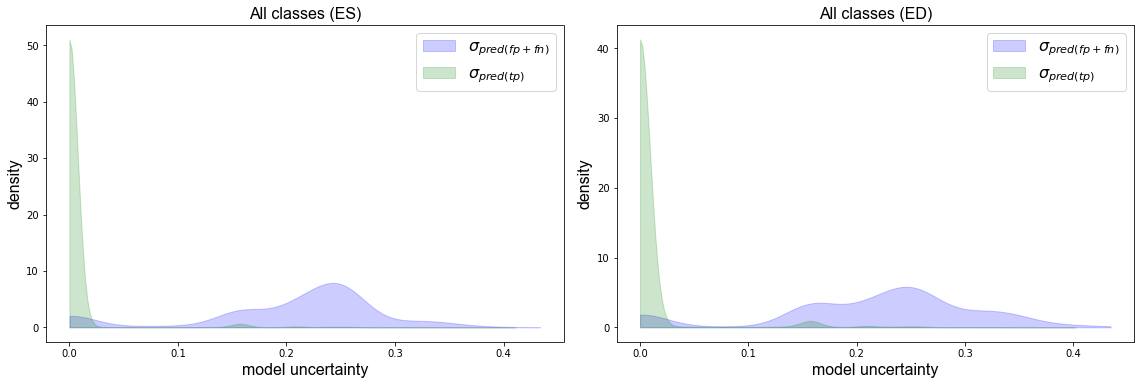

In [12]:
# info_type="uncertainty"  or probabilities
exper_hdl_mc.test_results.visualize_uncertainty_stats(image_num=0, width=16, height=10, info_type="uncertainty",
                                                     do_save=True)

(344272,)


Number of subplots 20 columns 5 rows 4 slices 0,1
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180308_12_05_35_dcnn_mcv1_150000E_lr2e02/figures/test_img0_vis_pred_0_1.png


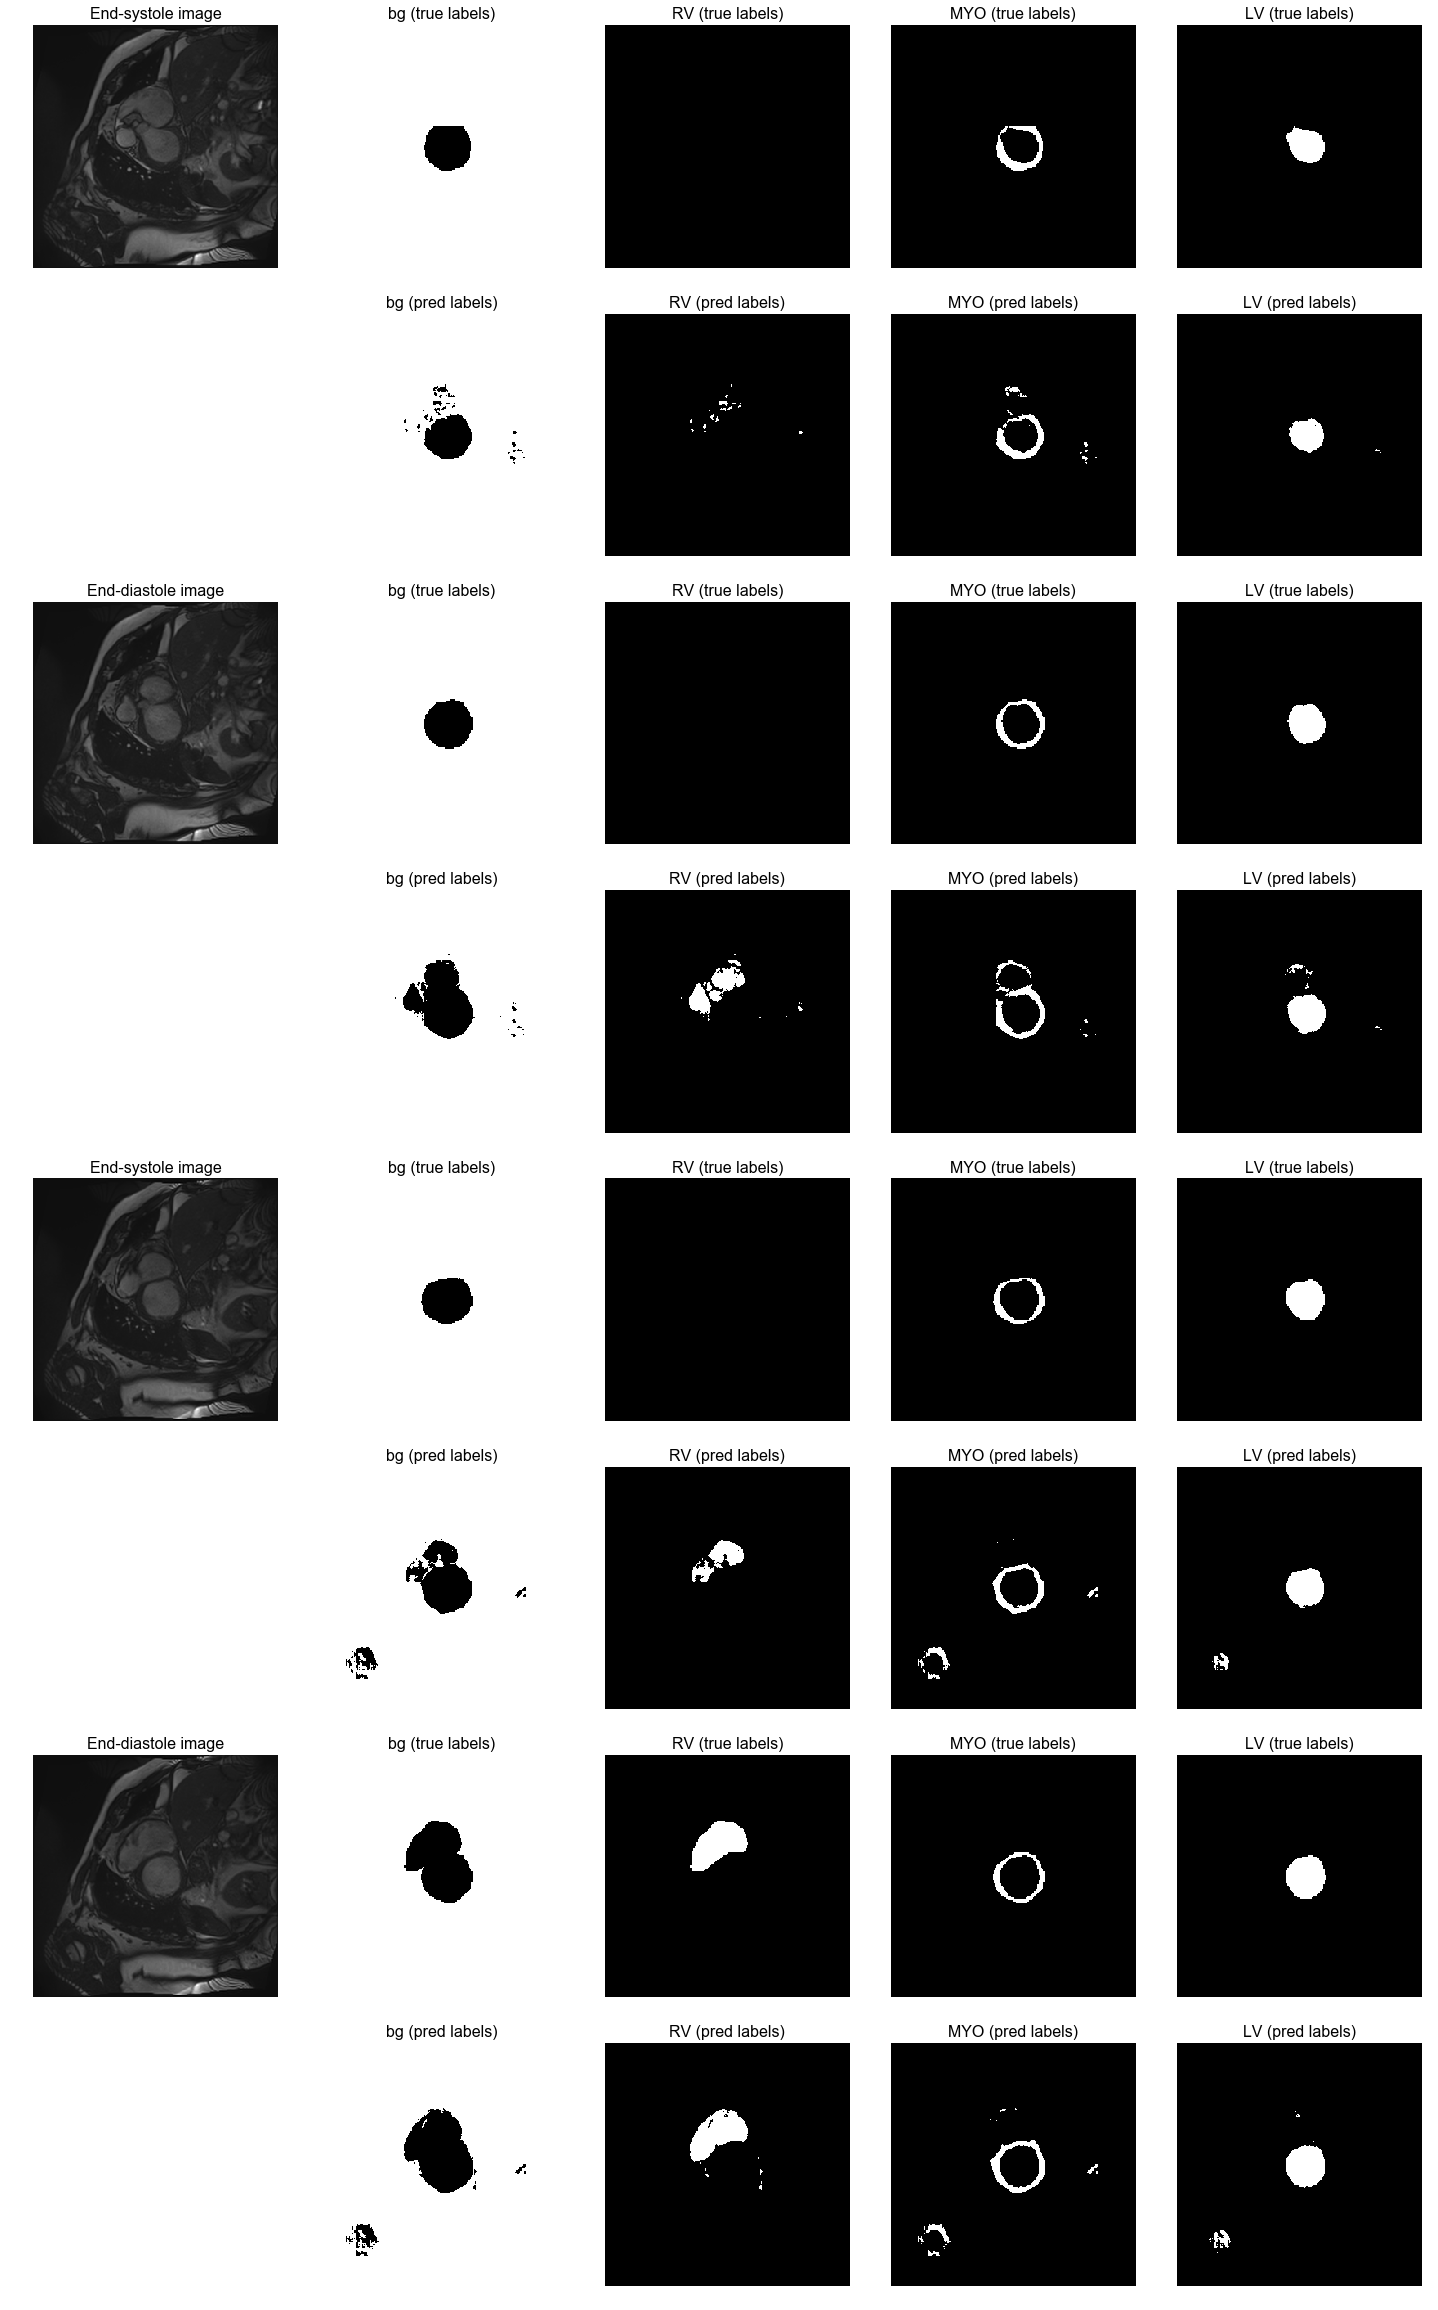

In [19]:
exper_hdl_mc.test_results.visualize_test_slices(width=20, height=80, slice_range=np.arange(2),
                                               do_save=True)

Number of subplots 30 columns 5 rows 2 slices 0,1,2
Slice 1 - ES - Class 1 before/after: errors 0 0 || dice 1.00 / 1.00 || hd  0.00 / 0.00
Slice 1 - ES - Class 2 before/after: errors 236 236 || dice 0.88 / 0.88 || hd  16.39 / 16.39
Slice 1 - ES - Class 3 before/after: errors 238 238 || dice 0.92 / 0.92 || hd  11.54 / 11.54
Slice 1 - ED - Class 1 before/after: errors 223 219 || dice 0.00 / 0.00 || hd  0.00 / 0.00
Slice 1 - ED - Class 2 before/after: errors 147 147 || dice 0.93 / 0.93 || hd  5.60 / 5.60
Slice 1 - ED - Class 3 before/after: errors 80 80 || dice 0.98 / 0.98 || hd  4.43 / 4.43
Slice 2 - ES - Class 1 before/after: errors 261 249 || dice 0.00 / 0.00 || hd  0.00 / 0.00
Slice 2 - ES - Class 2 before/after: errors 137 137 || dice 0.93 / 0.93 || hd  135.16 / 135.16
Slice 2 - ES - Class 3 before/after: errors 143 142 || dice 0.96 / 0.96 || hd  155.45 / 155.45
Slice 2 - ED - Class 1 before/after: errors 144 143 || dice 0.97 / 0.97 || hd  11.88 / 11.88
Slice 2 - ED - Class 2 before/

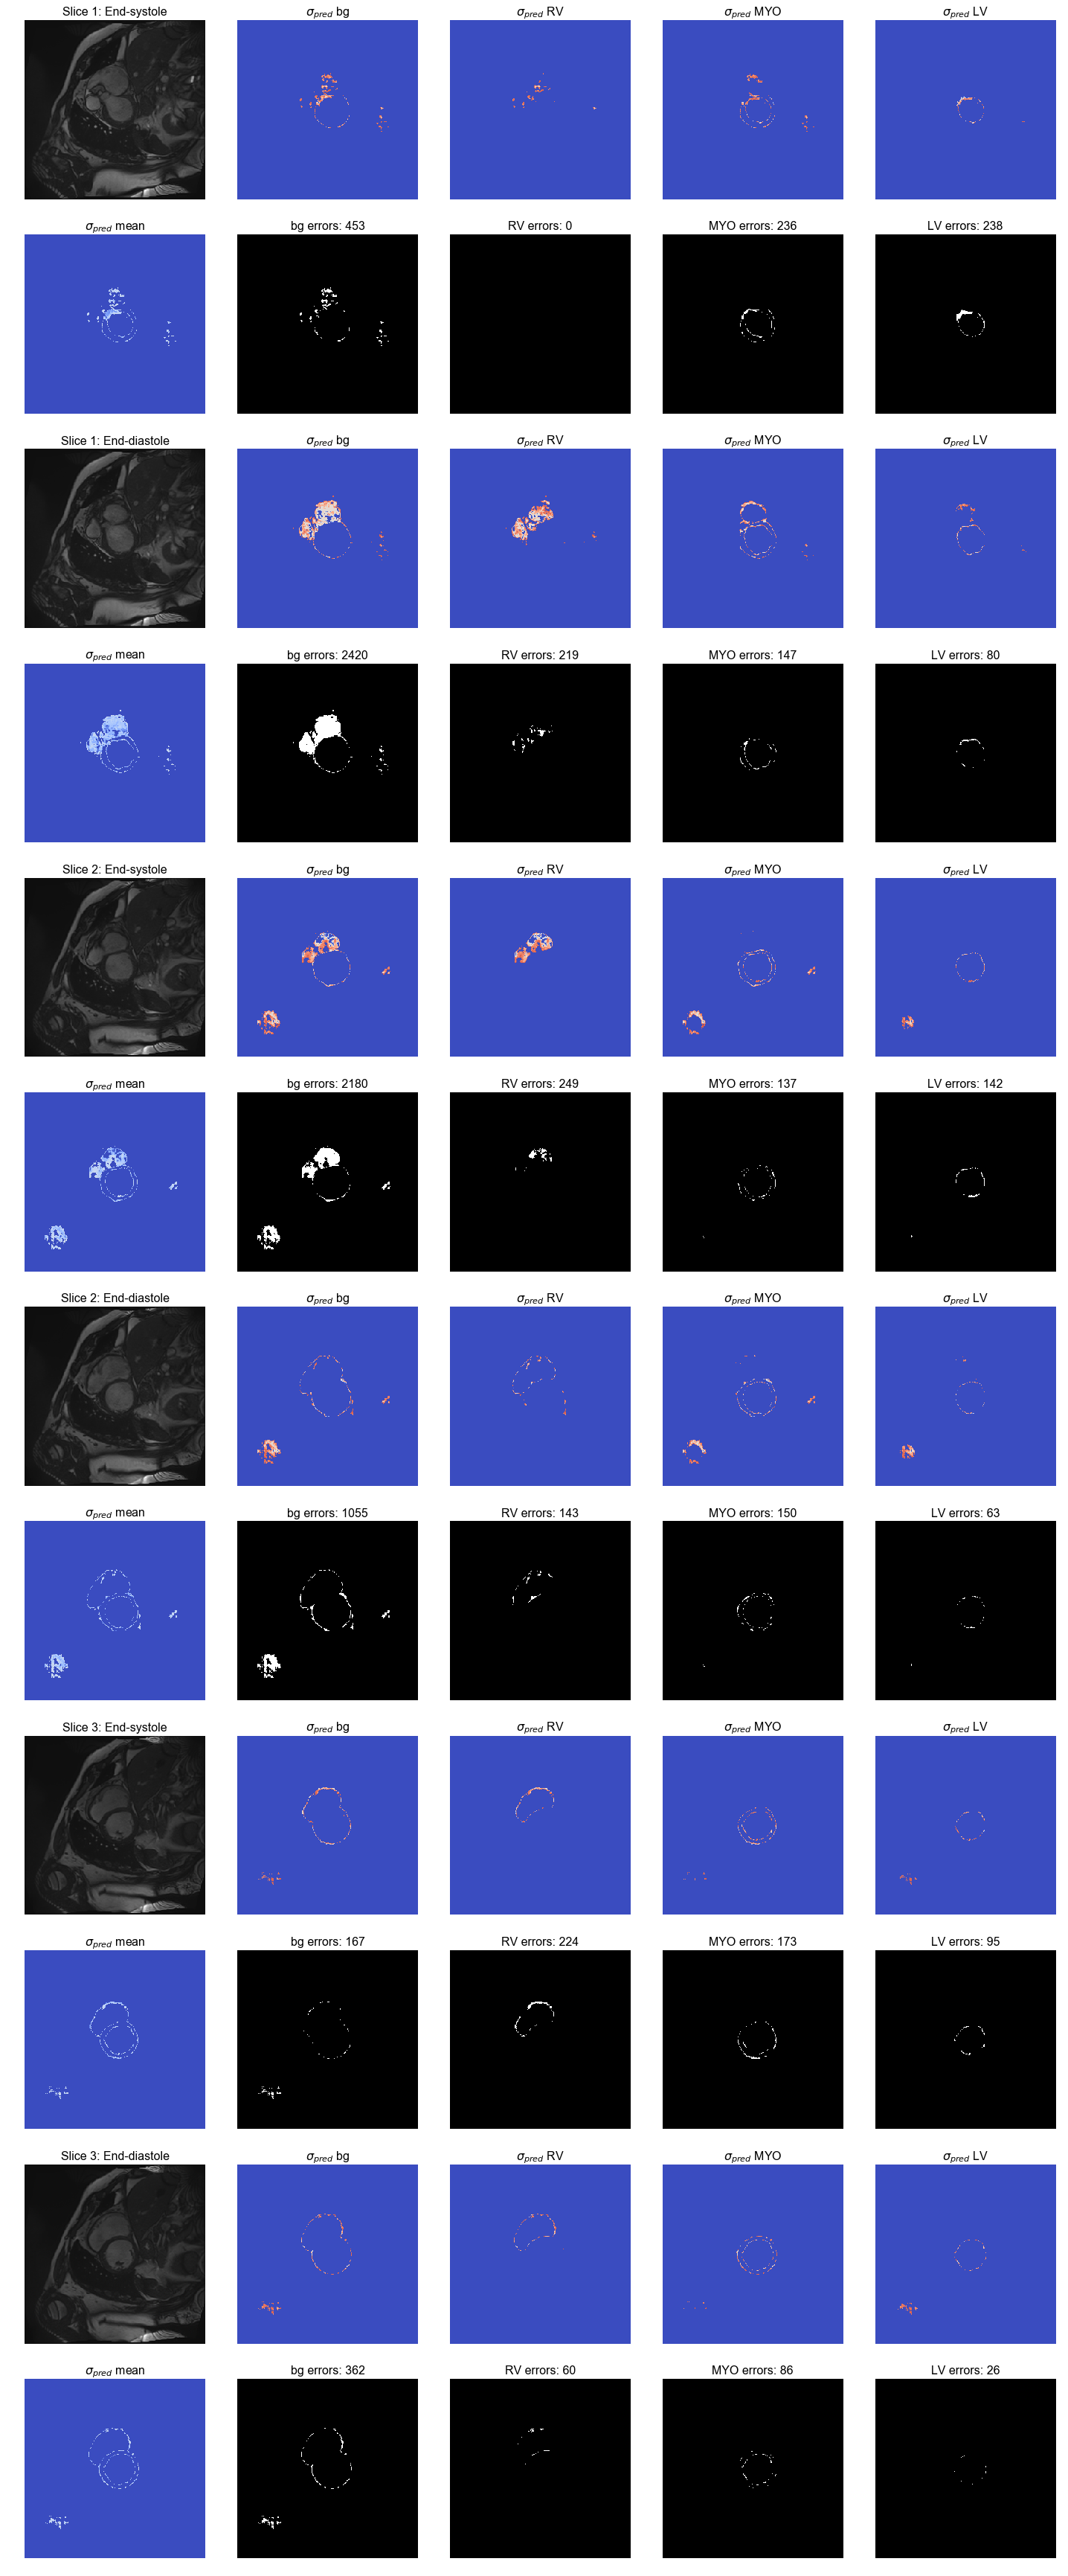

In [98]:
exper_hdl_mc.test_results.visualize_prediction_uncertainty(width=20, height=120, slice_range=[0, 1, 2], 
                                                           do_save=False, std_threshold=0.15)

Number of subplots 30 columns 5 rows 2 slices 0,1,2
Slice 1 - ES - Class 1: errors 0 || dice 1.00 || hd  0.00
Slice 1 - ES - Class 2: errors 311 || dice 0.85 || hd  17.03
Slice 1 - ES - Class 3: errors 254 || dice 0.91 || hd  22.40
Slice 1 - ED - Class 1: errors 0 || dice 1.00 || hd  0.00
Slice 1 - ED - Class 2: errors 385 || dice 0.83 || hd  49.97
Slice 1 - ED - Class 3: errors 175 || dice 0.95 || hd  46.05
Slice 2 - ES - Class 1: errors 5 || dice 0.00 || hd  0.00
Slice 2 - ES - Class 2: errors 311 || dice 0.85 || hd  4.43
Slice 2 - ES - Class 3: errors 134 || dice 0.96 || hd  3.96
Slice 2 - ED - Class 1: errors 207 || dice 0.96 || hd  14.28
Slice 2 - ED - Class 2: errors 236 || dice 0.88 || hd  5.60
Slice 2 - ED - Class 3: errors 78 || dice 0.98 || hd  2.80
Slice 3 - ES - Class 1: errors 163 || dice 0.96 || hd  10.66
Slice 3 - ES - Class 2: errors 229 || dice 0.91 || hd  3.13
Slice 3 - ES - Class 3: errors 83 || dice 0.98 || hd  2.80
Slice 3 - ED - Class 1: errors 185 || dice 0.96 ||

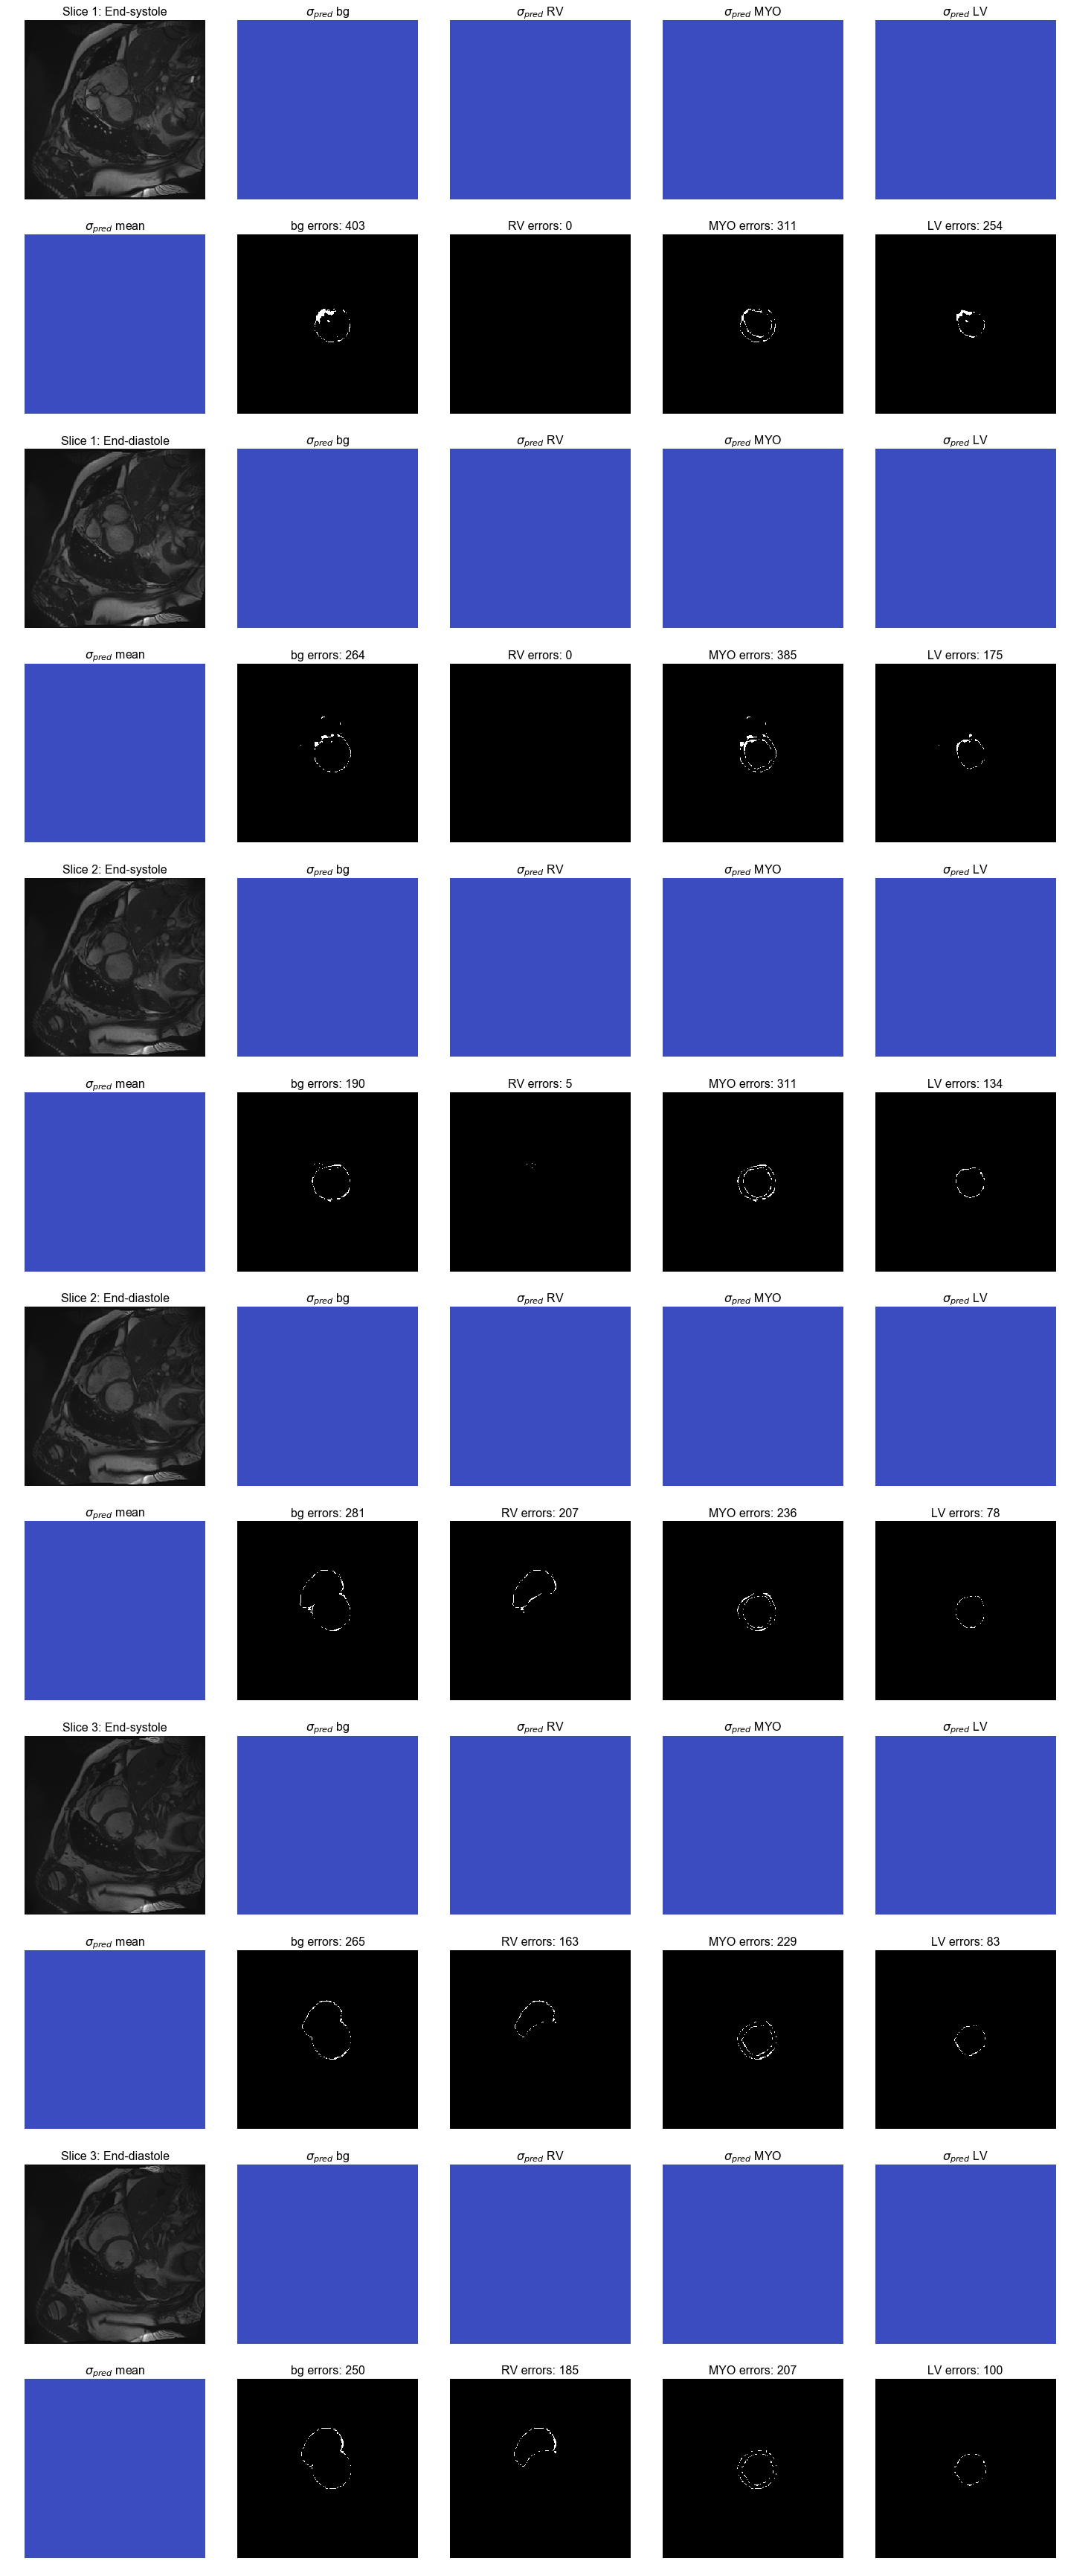

In [85]:
exper_hdl_base.test_results.visualize_prediction_uncertainty(width=20, height=120, slice_range=[0, 1, 2], 
                                                            do_save=False, std_threshold=None)

In [15]:
append_to_dir = os.path.join(exper_hdl_mc.exper.config.root_dir, exper_hdl_mc.exper.output_dir)
exper_hdl_mc.test_results.save_results()

Random number 815
INFO - Saved results to /home/jorg/repository/dcnn_acdc/logs/20180308_12_05_35_dcnn_mcv1_150000E_lr2e02/stats/test_results_2018_03_15_08_35.dll


In [9]:
from utils.test_results import TestResults
save_path = os.path.join(exper_hdl_mc.exper.config.root_dir, 
                         os.path.join(exper_hdl_mc.exper.output_dir, exper_hdl_mc.exper.config.stats_path))
save_path = os.path.join(save_path, "test_results_950.dll")
test_results = TestResults.load_results(save_path)


Load from /home/jorg/repository/dcnn_acdc/logs/20180308_12_05_35_dcnn_mcv1_150000E_lr2e02/stats/test_results_950.dll


In [10]:
print(len(test_results.images))

1


In [ ]:
# img_slice_stats = exper_hdl_mc.test_results.image_probs_categorized[0][0]
# print(img_slice_stats["es_mean_cor_p"].shape)
img = exper_hdl_mc.test_results.images[0]
fig = plt.figure(figsize=(12, 10))
img_slice = img[0][:, :, 5]
print(img_slice.shape)
fig, ax2 = plt.subplots(10, sharex=True, figsize=(10,100))
ax2[0].imshow(img_slice, cmap=cm.gray)
plt.show()